<a href="https://colab.research.BVHle.com/github/amanjain252002/Stock-Price-Prediction/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.BVHle.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
! pip install pmdarima matplotlib


In [126]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [127]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
ACB = pd.read_csv("./Database/Pre_Processed_ACB.csv")
BIDV = pd.read_csv("./Database/Pre_Processed_BIDV.csv")
BVH = pd.read_csv("./Database/Pre_Processed_BVH.csv")
CTG = pd.read_csv("./Database/Pre_Processed_CTG.csv")
FPT = pd.read_csv("./Database/Pre_Processed_FPT.csv")

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

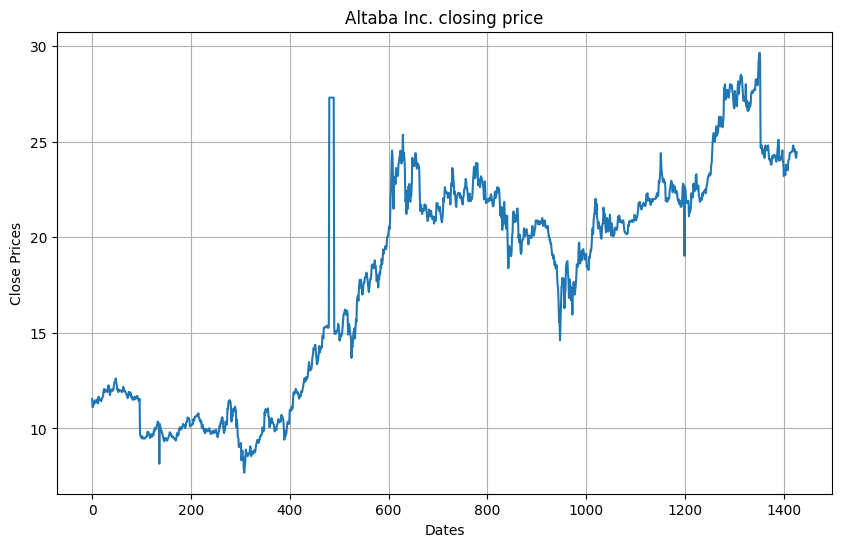

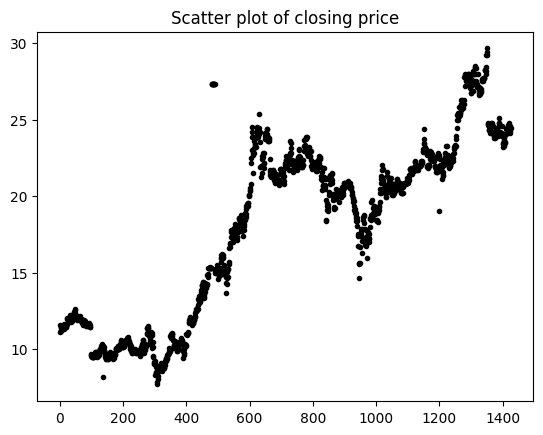

In [128]:
# Visualize the per day closing price of the stock.
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(ACB['Adj. Close'])
plt.title('Altaba Inc. closing price')
plt.show()

# Lets us plot the scatterplot:
df_close = ACB['Adj. Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

In [129]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Adj. Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#Apple

In [130]:
ACB.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02 00:00:00,11.703,11.693,11.416,11.544,1103106.0
1,2019-01-03 00:00:00,10.398,11.360,10.267,11.110,1956382.0
2,2019-01-04 00:00:00,11.070,11.413,11.052,11.189,2771983.0
3,2019-01-07 00:00:00,11.426,11.402,11.244,11.347,1305819.0
4,2019-01-08 00:00:00,12.414,12.378,11.235,11.268,846226.0


In [131]:
ACB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1427 non-null   object 
 1   Open        1427 non-null   float64
 2   High        1427 non-null   float64
 3   Low         1427 non-null   float64
 4   Adj. Close  1427 non-null   float64
 5   Volume      1427 non-null   float64
dtypes: float64(5), object(1)
memory usage: 67.0+ KB


In [132]:
# Change Dtype of Date column
ACB["Date"] = pd.to_datetime(ACB["Date"])

In [133]:
Test_Stationarity(ACB)

Results of Dickey Fuller Test
Test Statistics: -1.336210763429011
p-value: 0.6124473967936362
Number of lags used: 10
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

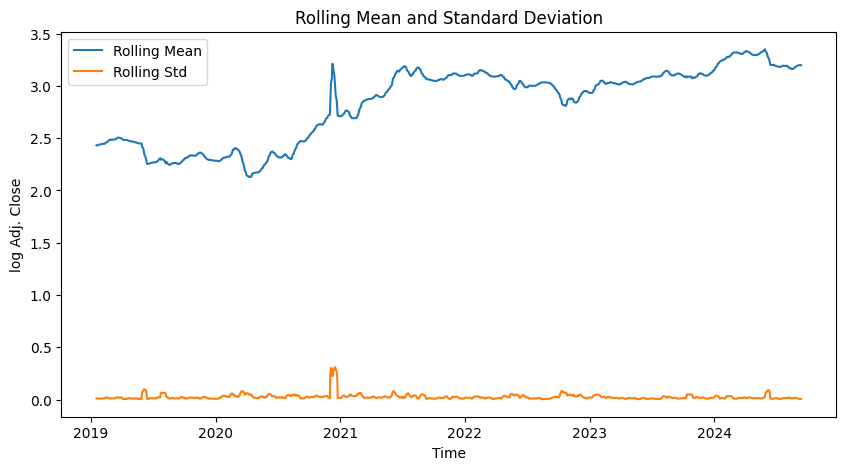

In [134]:
ACB['log Adj. Close'] = np.log(ACB['Adj. Close'])
ACB_log_moving_avg = ACB['log Adj. Close'].rolling(12).mean()
ACB_log_std = ACB['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(ACB['Date'], ACB_log_moving_avg, label = "Rolling Mean")
plt.plot(ACB['Date'], ACB_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set







(286, 7)


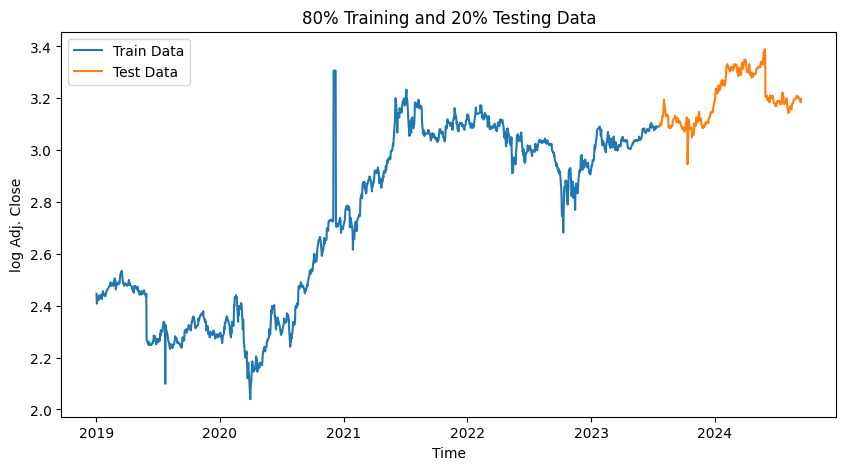

In [135]:
# Assuming ACB DataFrame is already defined and contains the necessary columns

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(ACB) * 0.8)

# Split the data into training and testing datasets
ACB_Train_Data = ACB.iloc[:cutoff_index]
ACB_Test_Data = ACB.iloc[cutoff_index:].reset_index(drop=True)

print(ACB_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(ACB_Train_Data['Date'], ACB_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(ACB_Test_Data['Date'], ACB_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

###Modeling

In [136]:
ACB_Auto_ARIMA_Model = auto_arima(ACB_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(ACB_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1141
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2279.579
Date:                Sun, 15 Sep 2024   AIC                          -4557.158
Time:                        07:28:30   BIC                          -4552.119
Sample:                             0   HQIC                         -4555.255
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   4.78e-06    224.277      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):           1446689.01
Prob(Q):                              0.20   Pr

In [137]:
from statsmodels.tsa.arima.model import ARIMA  # Correct import

# Fit ARIMA model
ACB_ARIMA_Model = ARIMA(ACB_Train_Data['log Adj. Close'], order=(1, 0, 1))
ACB_ARIMA_Model_Fit = ACB_ARIMA_Model.fit()

# Print the summary of the model
print(ACB_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2281.328
Date:                Sun, 15 Sep 2024   AIC                          -4554.656
Time:                        07:28:30   BIC                          -4534.498
Sample:                             0   HQIC                         -4547.044
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7417      0.206     13.294      0.000       2.337       3.146
ar.L1          0.9957      0.003    313.603      0.000       0.990       1.002
ma.L1         -0.0354      0.020     -1.799      0.0

### Predicting the closing stock price of ACB

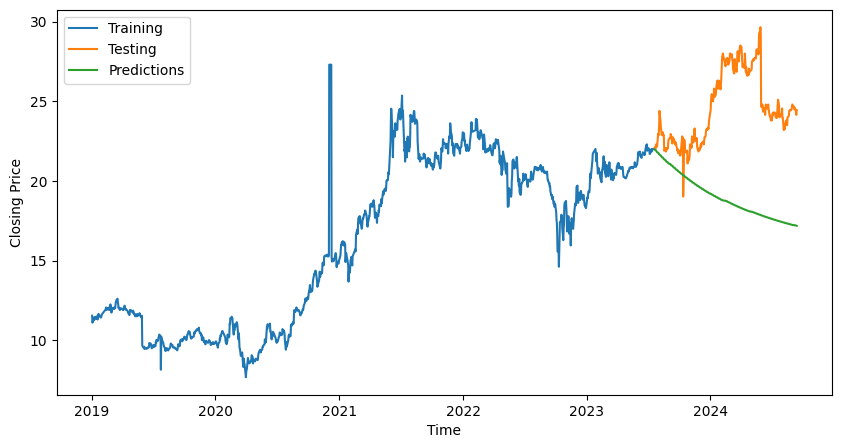

In [138]:
ACB_output = ACB_ARIMA_Model_Fit.forecast(286, alpha=0.05)
ACB_predictions = np.exp(ACB_output)
plt.figure(figsize=(10, 5))
plt.plot(ACB_Train_Data['Date'], ACB_Train_Data['Adj. Close'], label = 'Training')
plt.plot(ACB_Test_Data['Date'], ACB_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(ACB_Test_Data['Date'], ACB_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [139]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(ACB_Test_Data['Adj. Close'], ACB_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = ACB_Test_Data['Adj. Close'] != 0
ACB_Test_Non_Zero = ACB_Test_Data.loc[non_zero_mask]
ACB_Predictions_Non_Zero = ACB_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(ACB_Predictions_Non_Zero - ACB_Test_Non_Zero['Adj. Close'].values) / np.abs(ACB_Test_Non_Zero['Adj. Close'].values))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


RMSE: 6.342788228109312
MAPE: 0.21594612333713414


#Tesla

In [140]:
BIDV.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02 00:00:00,11.703,11.693,11.416,11.544,1103106.0
1,2019-01-03 00:00:00,10.398,11.360,10.267,11.110,1956382.0
2,2019-01-04 00:00:00,11.070,11.413,11.052,11.189,2771983.0
3,2019-01-07 00:00:00,11.426,11.402,11.244,11.347,1305819.0
4,2019-01-08 00:00:00,12.414,12.378,11.235,11.268,846226.0


In [141]:
BIDV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1427 non-null   object 
 1   Open        1427 non-null   float64
 2   High        1427 non-null   float64
 3   Low         1427 non-null   float64
 4   Adj. Close  1427 non-null   float64
 5   Volume      1427 non-null   float64
dtypes: float64(5), object(1)
memory usage: 67.0+ KB


In [142]:
# Change Dtype of Date column
BIDV["Date"] = pd.to_datetime(BIDV["Date"])

In [143]:
Test_Stationarity(BIDV)

Results of Dickey Fuller Test
Test Statistics: -1.336210763429011
p-value: 0.6124473967936362
Number of lags used: 10
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

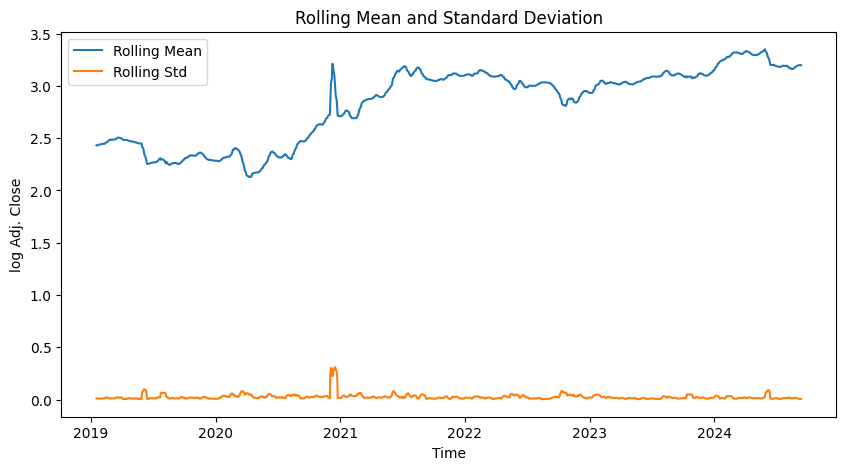

In [144]:
BIDV['log Adj. Close'] = np.log(BIDV['Adj. Close'])
BIDV_log_moving_avg = BIDV['log Adj. Close'].rolling(12).mean()
BIDV_log_std = BIDV['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(BIDV['Date'], BIDV_log_moving_avg, label = "Rolling Mean")
plt.plot(BIDV['Date'], BIDV_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

(286, 7)


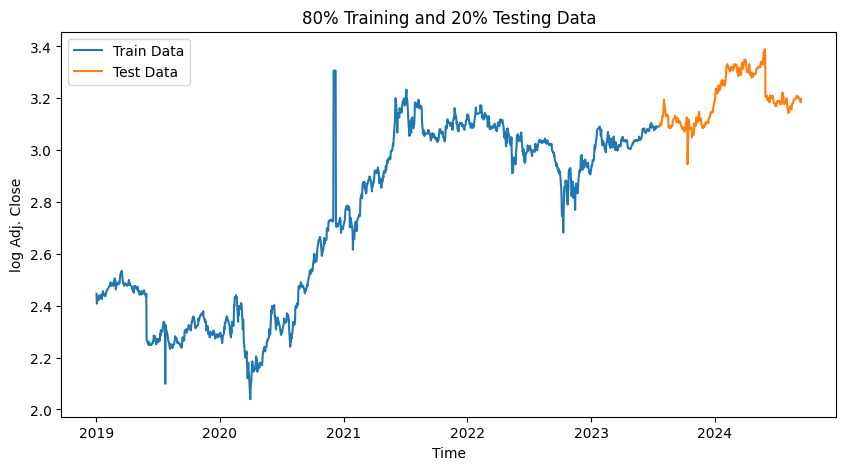

In [145]:


# Assuming ACB DataFrame is already defined and contains the necessary columns

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(BIDV) * 0.8)

# Split the data into training and testing datasets
BIDV_Train_Data = BIDV.iloc[:cutoff_index]
BIDV_Test_Data = BIDV.iloc[cutoff_index:].reset_index(drop=True)

print(BIDV_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(BIDV_Train_Data['Date'], BIDV_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(BIDV_Test_Data['Date'], BIDV_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

###Modeling

In [146]:
BIDV_Auto_ARIMA_Model = auto_arima(BIDV_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(BIDV_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1141
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2279.579
Date:                Sun, 15 Sep 2024   AIC                          -4557.158
Time:                        07:28:34   BIC                          -4552.119
Sample:                             0   HQIC                         -4555.255
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   4.78e-06    224.277      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):           1446689.01
Prob(Q):                              0.20   Pr

In [147]:
BIDV_ARIMA_Model = ARIMA(BIDV_Train_Data['log Adj. Close'], order = (5, 2, 2))
BIDV_ARIMA_Model_Fit = BIDV_ARIMA_Model.fit()
print(BIDV_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1141
Model:                 ARIMA(5, 2, 2)   Log Likelihood                2275.111
Date:                Sun, 15 Sep 2024   AIC                          -4534.222
Time:                        07:28:36   BIC                          -4493.919
Sample:                             0   HQIC                         -4519.001
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9608      0.026    -37.514      0.000      -1.011      -0.911
ar.L2         -0.0085      0.052     -0.163      0.870      -0.110       0.093
ar.L3          0.0079      0.073      0.108      0.9

###Predicting the closing stock price of Tesla

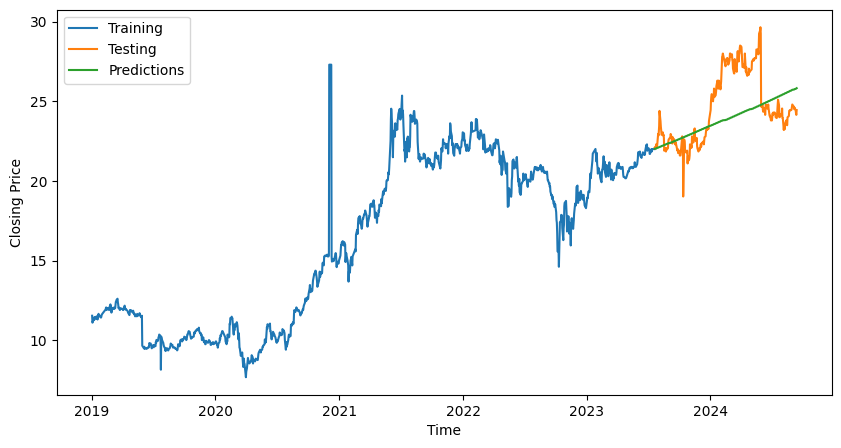

In [148]:
BIDV_output = BIDV_ARIMA_Model_Fit.forecast(286, alpha=0.05)
BIDV_predictions = np.exp(BIDV_output)
plt.figure(figsize=(10, 5))
plt.plot(BIDV_Train_Data['Date'], BIDV_Train_Data['Adj. Close'], label = 'Training')
plt.plot(BIDV_Test_Data['Date'], BIDV_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(BIDV_Test_Data['Date'], BIDV_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [149]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(BIDV_Test_Data['Adj. Close'], BIDV_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = BIDV_Test_Data['Adj. Close'] != 0
BIDV_Test_Non_Zero = BIDV_Test_Data.loc[non_zero_mask]
BIDV_Predictions_Non_Zero = BIDV_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(BIDV_Predictions_Non_Zero - BIDV_Test_Non_Zero['Adj. Close'].values) / np.abs(BIDV_Test_Non_Zero['Adj. Close'].values))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


RMSE: 2.0140376306060217
MAPE: 0.061034748233490595


# BVH

In [150]:
BVH.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02,79.787,79.787,78.119,78.119,87080.0
1,2019-01-03,79.436,79.875,77.593,78.295,55310.0
2,2019-01-04,78.295,78.295,75.486,77.768,96940.0
3,2019-01-07,78.558,79.699,76.978,77.768,92970.0
4,2019-01-08,77.768,77.768,77.241,77.417,36610.0


In [151]:
BVH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1422 non-null   object 
 1   Open        1422 non-null   float64
 2   High        1422 non-null   float64
 3   Low         1422 non-null   float64
 4   Adj. Close  1422 non-null   float64
 5   Volume      1422 non-null   float64
dtypes: float64(5), object(1)
memory usage: 66.8+ KB


In [152]:
# Change Dtype of Date column
BVH["Date"] = pd.to_datetime(BVH["Date"])

In [153]:
Test_Stationarity(BVH)

Results of Dickey Fuller Test
Test Statistics: -2.5983560025610717
p-value: 0.09333752455170535
Number of lags used: 1
Number of observations used: 1420
critical value (1%): -3.4349634933241084
critical value (5%): -2.8635775363009244
critical value (10%): -2.5678547733584605


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

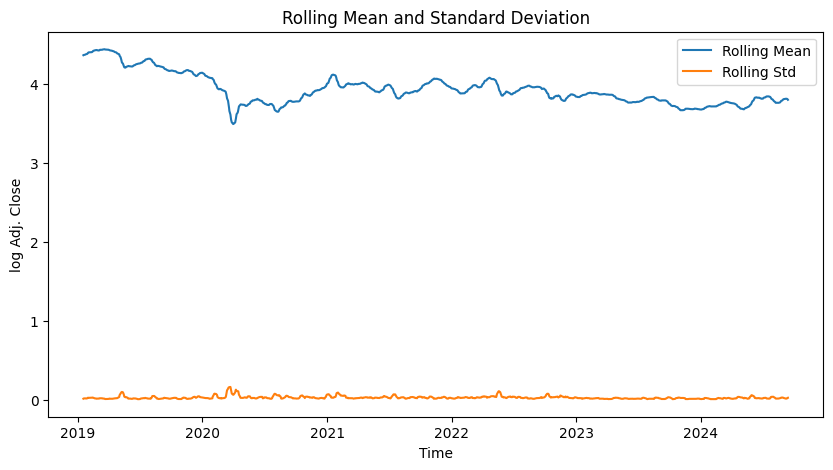

In [154]:
BVH['log Adj. Close'] = np.log(BVH['Adj. Close'])
BVH_log_moving_avg = BVH['log Adj. Close'].rolling(12).mean()
BVH_log_std = BVH['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(BVH['Date'], BVH_log_moving_avg, label = "Rolling Mean")
plt.plot(BVH['Date'], BVH_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set
   

(285, 7)


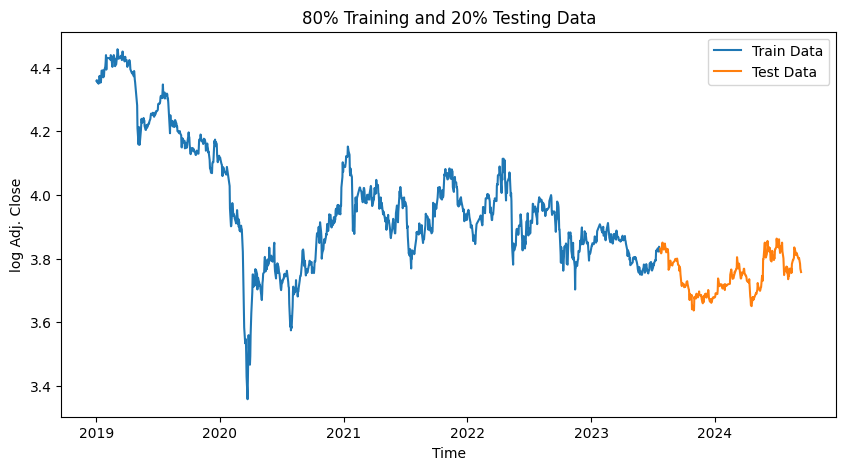

In [155]:

# Assuming ACB DataFrame is already defined and contains the necessary columns

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(BVH) * 0.8)

# Split the data into training and testing datasets
BVH_Train_Data = BVH.iloc[:cutoff_index]
BVH_Test_Data = BVH.iloc[cutoff_index:].reset_index(drop=True)

print(BVH_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(BVH_Train_Data['Date'], BVH_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(BVH_Test_Data['Date'], BVH_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

### Modeling

In [156]:
BVH_Auto_ARIMA_Model = auto_arima(BVH_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)

print(BVH_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1137
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2724.841
Date:                Sun, 15 Sep 2024   AIC                          -5445.681
Time:                        07:28:40   BIC                          -5435.611
Sample:                             0   HQIC                         -5441.878
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0852      0.020      4.289      0.000       0.046       0.124
sigma2         0.0005   1.49e-05     32.476      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [157]:

# Thử với order (p=1, d=1, q=1)
BVH_ARIMA_Model = ARIMA(BVH_Train_Data['log Adj. Close'], order=(1, 1, 1))
BVH_ARIMA_Model_Fit = BVH_ARIMA_Model.fit()
print(BVH_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1137
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2724.843
Date:                Sun, 15 Sep 2024   AIC                          -5443.685
Time:                        07:28:40   BIC                          -5428.579
Sample:                             0   HQIC                         -5437.980
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0171      0.250      0.068      0.945      -0.473       0.507
ma.L1          0.0681      0.255      0.267      0.790      -0.432       0.568
sigma2         0.0005   1.49e-05     32.475      0.0

### Predicting the closing stock price of BVH

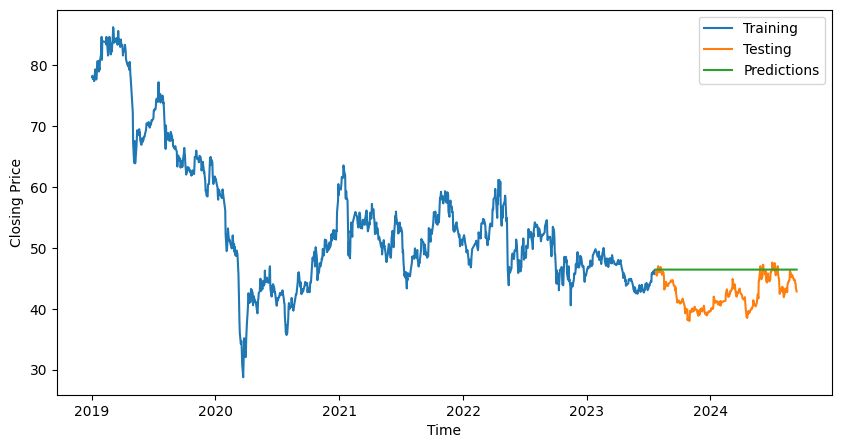

In [158]:
BVH_output = BVH_ARIMA_Model_Fit.forecast(285, alpha=0.05)
BVH_predictions = np.exp(BVH_output)
plt.figure(figsize=(10, 5))
plt.plot(BVH_Train_Data['Date'], BVH_Train_Data['Adj. Close'], label = 'Training')
plt.plot(BVH_Test_Data['Date'], BVH_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(BVH_Test_Data['Date'], BVH_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [159]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(BVH_Test_Data['Adj. Close'], BVH_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = BVH_Test_Data['Adj. Close'] != 0
BVH_Test_Non_Zero = BVH_Test_Data.loc[non_zero_mask]
BVH_Predictions_Non_Zero = BVH_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(BVH_Predictions_Non_Zero - BVH_Test_Non_Zero['Adj. Close'].values) / np.abs(BVH_Test_Non_Zero['Adj. Close'].values))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


RMSE: 4.565865954008009
MAPE: 0.09523211197933015


# Vietinbank

In [160]:
CTG.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02,12.844,12.978,12.677,12.677,2420340.0
1,2019-01-03,12.677,12.811,12.043,12.077,5513360.0
2,2019-01-04,12.043,12.377,11.810,12.244,3804290.0
3,2019-01-07,12.544,12.544,12.110,12.110,3982660.0
4,2019-01-08,12.177,12.177,11.877,11.943,5636280.0


In [161]:
CTG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1422 non-null   object 
 1   Open        1422 non-null   float64
 2   High        1422 non-null   float64
 3   Low         1422 non-null   float64
 4   Adj. Close  1422 non-null   float64
 5   Volume      1422 non-null   float64
dtypes: float64(5), object(1)
memory usage: 66.8+ KB


In [162]:
# Change Dtype of Date column
CTG["Date"] = pd.to_datetime(CTG["Date"])

In [163]:
Test_Stationarity(CTG)

Results of Dickey Fuller Test
Test Statistics: -1.3761977387688442
p-value: 0.5936325425261936
Number of lags used: 5
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

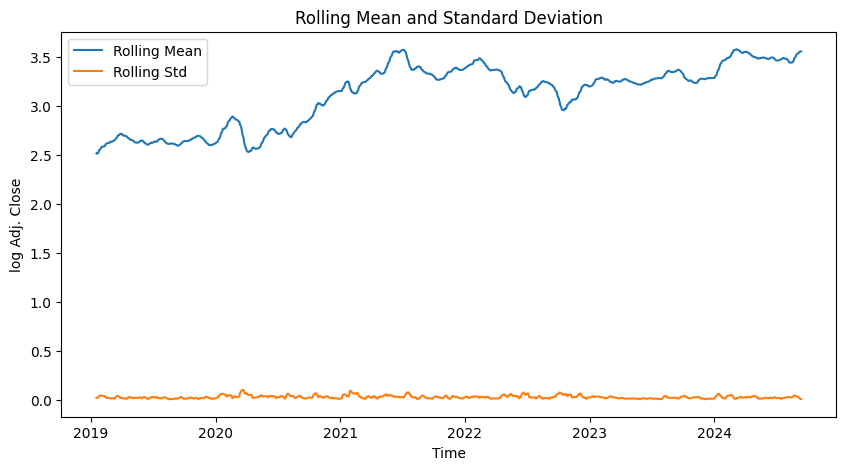

In [164]:
CTG['log Adj. Close'] = np.log(CTG['Adj. Close'])
CTG_log_moving_avg = CTG['log Adj. Close'].rolling(12).mean()
CTG_log_std = CTG['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(CTG['Date'], CTG_log_moving_avg, label = "Rolling Mean")
plt.plot(CTG['Date'], CTG_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set


(285, 7)


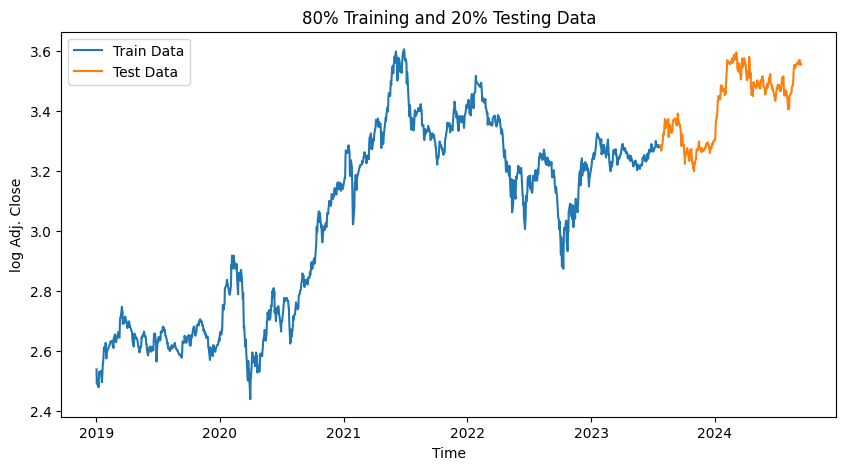

In [169]:

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(BVH) * 0.8)

# Split the data into training and testing datasets
CTG_Train_Data = CTG.iloc[:cutoff_index]
CTG_Test_Data = CTG.iloc[cutoff_index:].reset_index(drop=True)

print(BVH_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(CTG_Train_Data['Date'], CTG_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(CTG_Test_Data['Date'], CTG_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

### Modeling

In [178]:
CTG_Auto_ARIMA_Model = auto_arima(CTG_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(CTG_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1137
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2698.653
Date:                Sun, 15 Sep 2024   AIC                          -5395.307
Time:                        07:33:55   BIC                          -5390.271
Sample:                             0   HQIC                         -5393.405
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.52e-05     33.194      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):               182.43
Prob(Q):                              0.18   Pr

In [216]:
from statsmodels.tsa.arima.model import ARIMA
CTG_ARIMA_Model = ARIMA(CTG_Train_Data['log Adj. Close'], order=(1, 3, 1))
CTG_ARIMA_Model_Fit = CTG_ARIMA_Model.fit()
print(CTG_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1137
Model:                 ARIMA(1, 3, 1)   Log Likelihood                2449.202
Date:                Sun, 15 Sep 2024   AIC                          -4892.404
Time:                        07:39:35   BIC                          -4877.304
Sample:                             0   HQIC                         -4886.700
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5137      0.021    -23.994      0.000      -0.556      -0.472
ma.L1         -0.9998      0.266     -3.760      0.000      -1.521      -0.479
sigma2         0.0008      0.000      3.682      0.0

### Predicting the closing stock price of Vietinbank

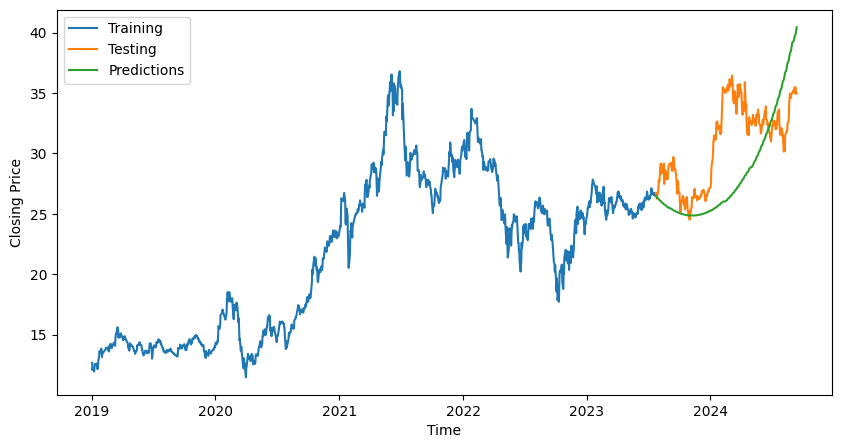

In [217]:
CTG_output = CTG_ARIMA_Model_Fit.forecast(285, alpha=0.05)
CTG_predictions = np.exp(CTG_output)
plt.figure(figsize=(10, 5))
plt.plot(CTG_Train_Data['Date'], CTG_Train_Data['Adj. Close'], label = 'Training')
plt.plot(CTG_Test_Data['Date'], CTG_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(CTG_Test_Data['Date'], CTG_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [218]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(CTG_Test_Data['Adj. Close'], BVH_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = CTG_Test_Data['Adj. Close'] != 0
CTG_Test_Non_Zero = CTG_Test_Data.loc[non_zero_mask]
CTG_Predictions_Non_Zero = CTG_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(CTG_Predictions_Non_Zero - CTG_Test_Non_Zero['Adj. Close'].values) / np.abs(CTG_Test_Non_Zero['Adj. Close'].values)*100)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


RMSE: 16.087823422026762
MAPE: 10.935943787193288


# FPT

In [219]:
FPT.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02,18.247,18.400,17.964,17.985,459120.0
1,2019-01-03,18.095,18.095,17.767,17.811,716600.0
2,2019-01-04,17.723,18.095,17.680,17.942,318570.0
3,2019-01-07,18.247,18.378,18.160,18.247,408470.0
4,2019-01-08,18.247,18.335,18.204,18.335,295660.0


In [220]:
FPT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1422 non-null   object 
 1   Open        1422 non-null   float64
 2   High        1422 non-null   float64
 3   Low         1422 non-null   float64
 4   Adj. Close  1422 non-null   float64
 5   Volume      1422 non-null   float64
dtypes: float64(5), object(1)
memory usage: 66.8+ KB


In [221]:
# Change Dtype of Date column
FPT["Date"] = pd.to_datetime(FPT["Date"])

In [222]:
Test_Stationarity(FPT)

Results of Dickey Fuller Test
Test Statistics: 2.0875322160259455
p-value: 0.9987764349240807
Number of lags used: 21
Number of observations used: 1400
critical value (1%): -3.435029521805029
critical value (5%): -2.8636066747959186
critical value (10%): -2.5678702903061223


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

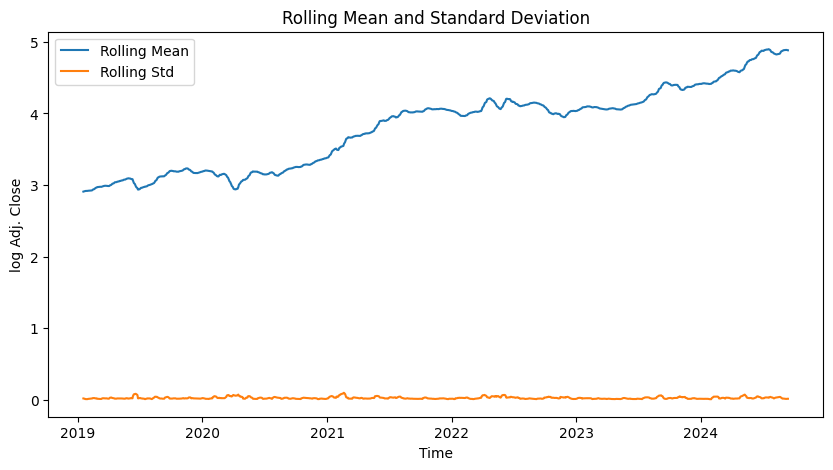

In [223]:
FPT['log Adj. Close'] = np.log(FPT['Adj. Close'])
FPT_log_moving_avg = FPT['log Adj. Close'].rolling(12).mean()
FPT_log_std = FPT['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(FPT['Date'], FPT_log_moving_avg, label = "Rolling Mean")
plt.plot(FPT['Date'], FPT_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

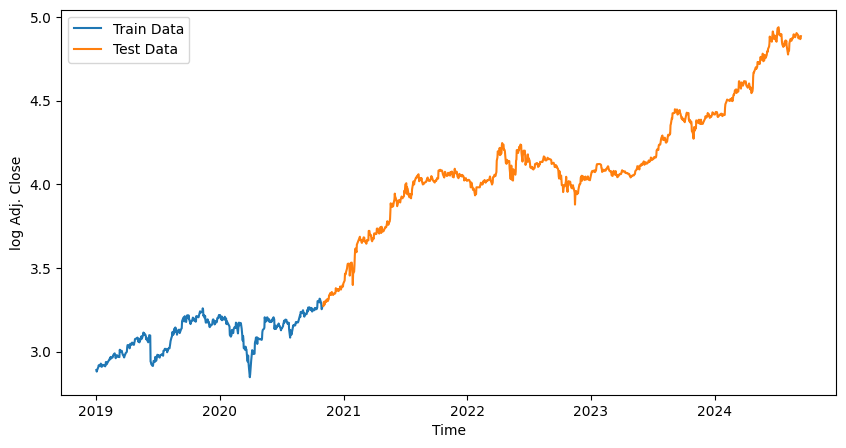

In [224]:
FPT_Train_Data = FPT[FPT['Date'] < '2020-11-01']
FPT_Test_Data = FPT[FPT['Date'] >= '2020-11-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(FPT_Train_Data['Date'], FPT_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(FPT_Test_Data['Date'], FPT_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [225]:
FPT_Auto_ARIMA_Model = auto_arima(FPT_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(FPT_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  458
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1186.326
Date:                Sun, 15 Sep 2024   AIC                          -2370.652
Time:                        07:55:30   BIC                          -2366.528
Sample:                             0   HQIC                         -2369.028
                                - 458                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   7.67e-06     42.429      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4003.65
Prob(Q):                              0.82   Pr

In [226]:
FPT_ARIMA_Model = ARIMA(FPT_Train_Data['log Adj. Close'], order = (0, 1, 0))
FPT_ARIMA_Model_Fit = FPT_ARIMA_Model.fit()
print(FPT_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                  458
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1186.326
Date:                Sun, 15 Sep 2024   AIC                          -2370.652
Time:                        07:55:30   BIC                          -2366.528
Sample:                             0   HQIC                         -2369.028
                                - 458                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   7.67e-06     42.429      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4003.65
Prob(Q):                              0.82   Pr

###Predicting the closing stock price of Amazon

ValueError: x and y must have same first dimension, but have shapes (964,) and (80,)

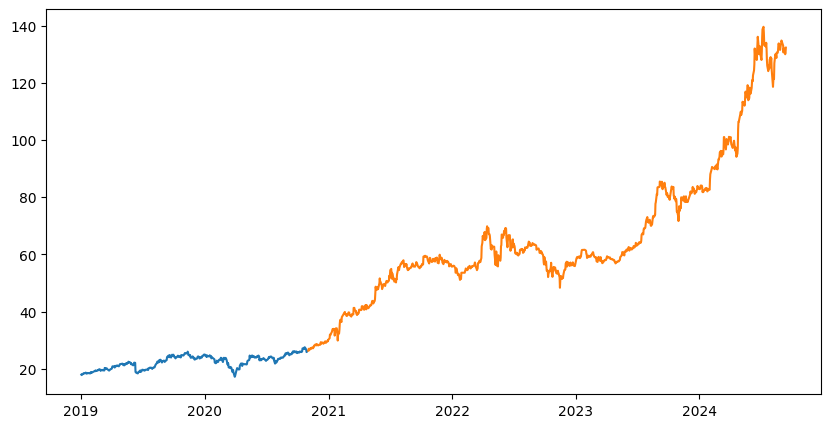

In [227]:
FPT_output = FPT_ARIMA_Model_Fit.forecast(80, alpha=0.05)
FPT_predictions = np.exp(FPT_output)
plt.figure(figsize=(10, 5))
plt.plot(FPT_Train_Data['Date'], FPT_Train_Data['Adj. Close'], label = 'Training')
plt.plot(FPT_Test_Data['Date'], FPT_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(FPT_Test_Data['Date'], FPT_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(FPT_Test_Data['Adj. Close'], FPT_predictions))
mape = np.mean(np.abs(FPT_predictions - FPT_Test_Data['Adj. Close'])/np.abs(FPT_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')